In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns


torch.cuda.set_device(0) 


def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"

In [15]:
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 0.5 percent of the samples
y=y[y.columns[y.sum()>(0.005*y.shape[0])]]
y.sum()
y.reset_index(drop=True)

,right bundle branch block,ventricular ectopics,atrial fibrillation,left bundle branch block,st elevation,1st degree av block,premature atrial contraction,sinus rhythm,st depression
0,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False
2,False,False,True,False,False,False,False,False,False
3,False,False,True,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
6872,False,False,False,False,False,True,False,False,False
6873,False,False,False,False,False,False,False,False,True
6874,False,False,False,True,False,False,False,False,False
6875,False,False,True,False,False,False,False,False,False


In [16]:
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


[I 2022-03-18 15:02:56,110] Using an existing study with name 'hyper_param_search' instead of creating a new one.


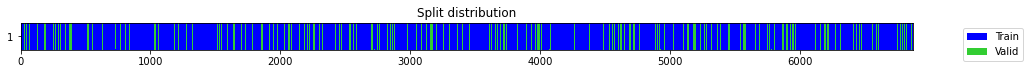

epoch,train_loss,valid_loss,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.330453,0.273744,0.830502,0.314392,0.991289,0.455244,00:09
1,0.229821,0.209541,0.755138,0.540233,0.976163,0.628946,00:08
2,0.187767,0.183016,0.809378,0.572454,0.981752,0.670283,00:09
3,0.167493,0.164710,0.835829,0.643603,0.982948,0.726721,00:08
4,0.156951,0.174342,0.841030,0.591888,0.984873,0.694338,00:09
5,0.149077,0.175563,0.793092,0.628590,0.977900,0.700884,00:09
6,0.144406,0.172010,0.818122,0.633474,0.981014,0.713771,00:08
7,0.136892,0.157011,0.807375,0.678050,0.978180,0.736704,00:08
8,0.136987,0.174508,0.790610,0.657176,0.976526,0.717501,00:09
9,0.127915,0.158535,0.865013,0.652431,0.986248,0.743184,00:08


In [ ]:
from transformation_funcs import *
        
def objective(trial:optuna.Trial):    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
#     
    tfms = []
    depth = trial.suggest_int('depth', 7,14,step=1) # search through all integer values between 3 and 9 with 3 increment steps
    L2 = trial.suggest_uniform("L2", 1e-7, 1e-3) 
    LR = trial.suggest_uniform("LR", 1e-5, 1e-1)
    rand_state = trial.suggest_int('rand_state', 0,20,step=1)
#     use_loss_weights = trial.suggest_categorical("loss_weights", [True,False]) 
    batch_tfms = [
        TSStandardize(by_sample=True),
        tfs.RandomShift(0.1),
        tfs.MulNoise(0.5),
        tfs.CutOutWhenTraining(),
        tfs.Scale(scale_factor=0.3)
     ]

    
    tfms = [None,TSMultiLabelClassification()]
    splits = get_splits(y.to_numpy(), valid_size=0.2,test_size=0, stratify=False, random_state=rand_state, shuffle=True)
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics = [precision_multi, recall_multi, specificity_multi, F1_multi] 
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=depth,)
    
    # reorganize y dataframe using dl's label/vocab mapping and count pos_weights
#     y = y[dls.vocab.o2i.keys()]
#     pos_weight = torch.tensor((len(y)-y.sum())/(y.sum()+1e-5))
#     pos_weight = pos_weight**(0.25)
#     loss_func = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if use_loss_weights else nn.BCEWithLogitsLoss()
    #
    
    learn = Learner(dls, model, metrics=metrics,loss_func=nn.BCEWithLogitsLoss(),
                    opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=L2),
                    cbs=FastAIPruningCallback(trial,monitor="F1_multi"))
    learn.recorder.silent = True 
    learn.fit_one_cycle(500, lr_max=LR)
    # get best f1 every scored
    f1 = np.max(np.array(learn.recorder.values)[:,-1])
    if f1>0.84:
        PATH = Path('./models/inception_hyperparam_%s.pkl'%f1)
        PATH.parent.mkdir(parents=True, exist_ok=True)
        learn.export(PATH)
    # Return the objective value
    return f1 # return the f1 value and try to maximize it

study_name = "hyper_param_search" # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name,direction='maximize',load_if_exists=True,
                            pruner=optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(),patience=25),
                           sampler=optuna.samplers.RandomSampler())

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study.optimize(objective, n_trials=100,)